[Episode 0] Steps: 100, Total attached counter: 17, Total transl: 97, Total rot: 17, Final distance: 0.0080, Final rot error: 0.2524, Success: False


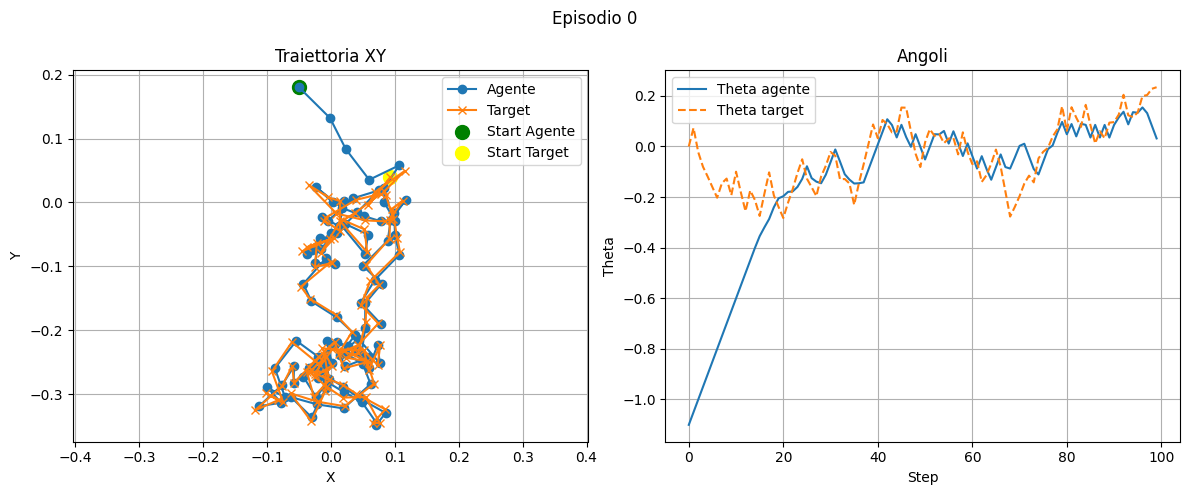

[Episode 1] Steps: 100, Total attached counter: 5, Total transl: 96, Total rot: 5, Final distance: 0.0059, Final rot error: 3.8481, Success: False


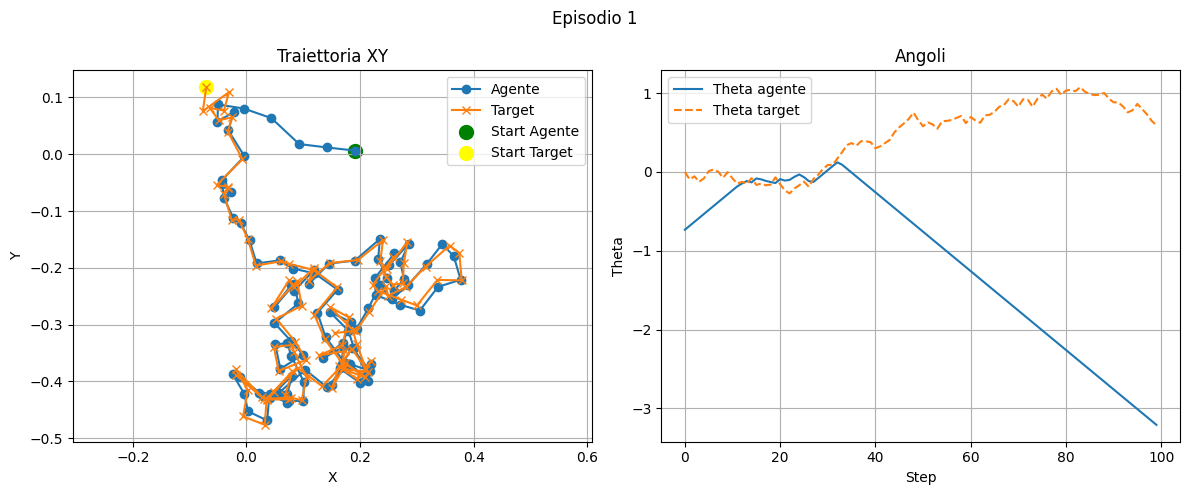

[Episode 2] Steps: 100, Total attached counter: 0, Total transl: 93, Total rot: 0, Final distance: 0.0058, Final rot error: 2.2920, Success: False


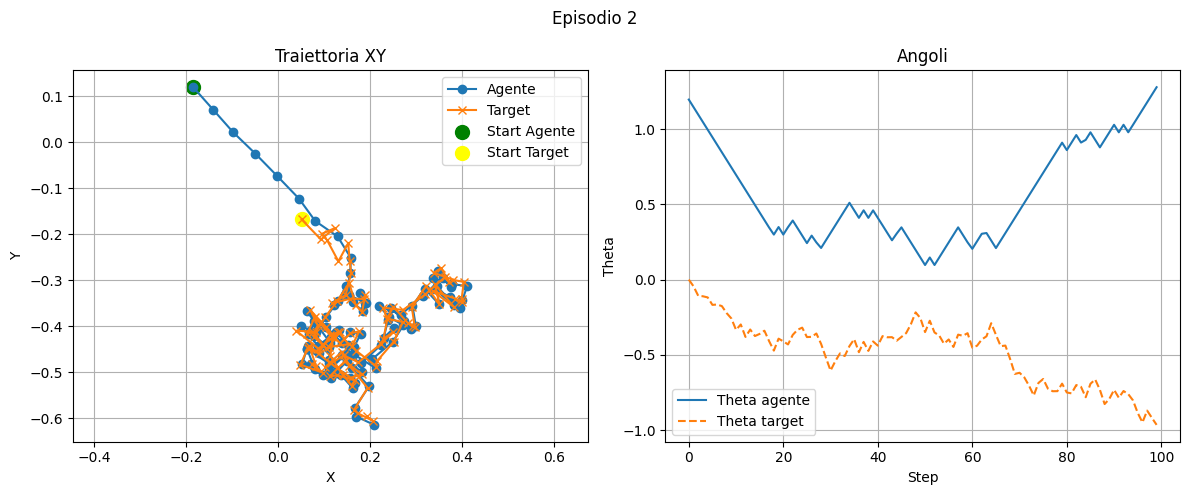

[Episode 3] Steps: 100, Total attached counter: 9, Total transl: 94, Total rot: 9, Final distance: 0.0127, Final rot error: 0.4650, Success: False


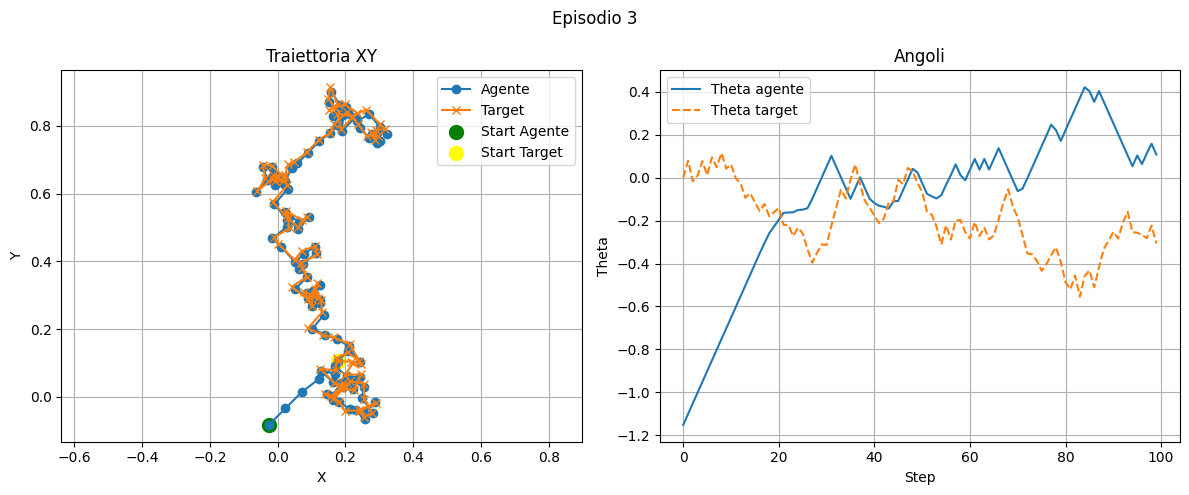

[Episode 4] Steps: 100, Total attached counter: 20, Total transl: 96, Total rot: 21, Final distance: 0.0006, Final rot error: 0.0296, Success: False


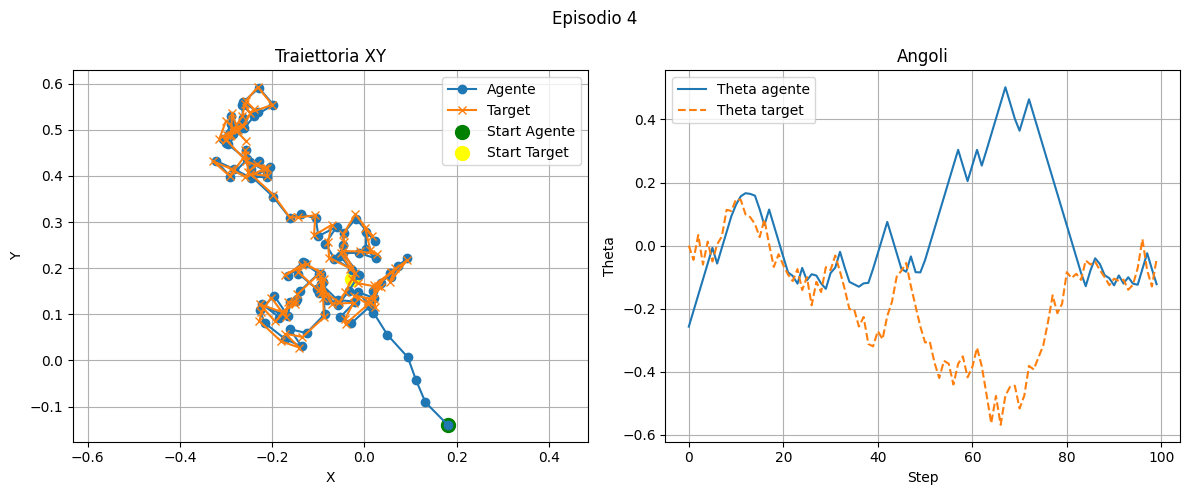

[Episode 5] Steps: 100, Total attached counter: 4, Total transl: 96, Total rot: 5, Final distance: 0.0116, Final rot error: 3.6312, Success: False


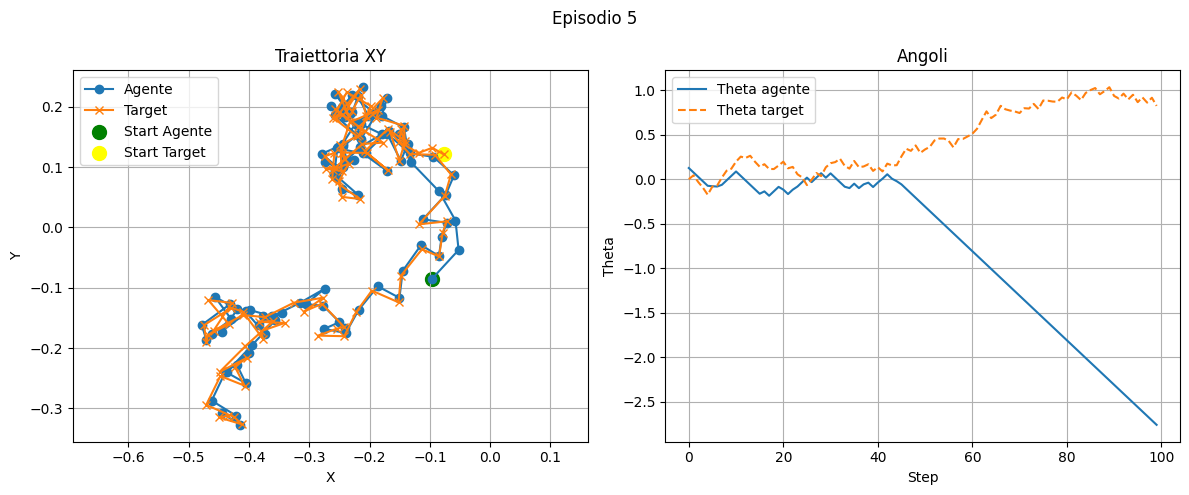

[Episode 6] Steps: 100, Total attached counter: 6, Total transl: 98, Total rot: 6, Final distance: 0.0017, Final rot error: 2.2034, Success: False


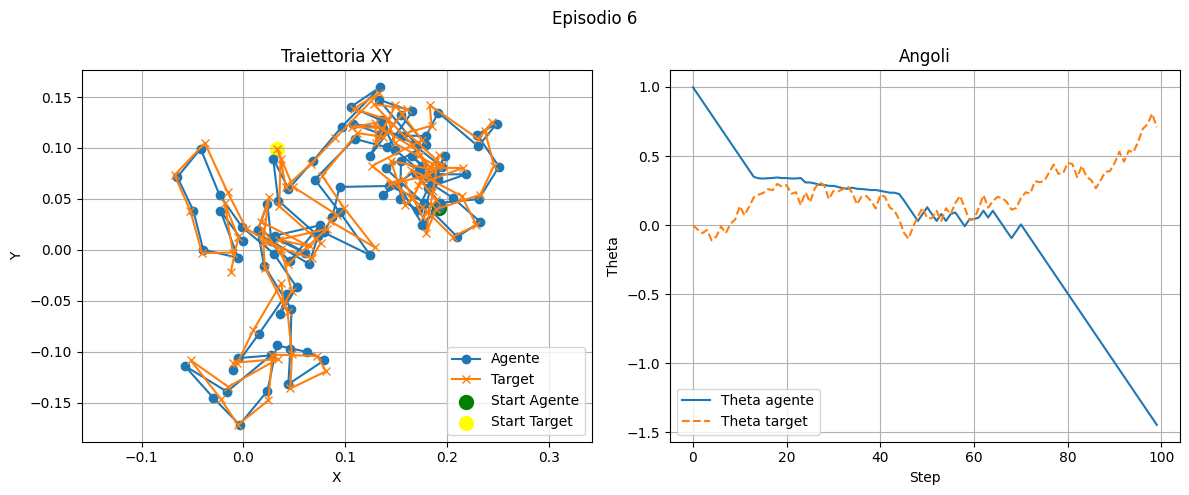

[Episode 7] Steps: 100, Total attached counter: 21, Total transl: 100, Total rot: 21, Final distance: 0.0101, Final rot error: 0.4776, Success: False


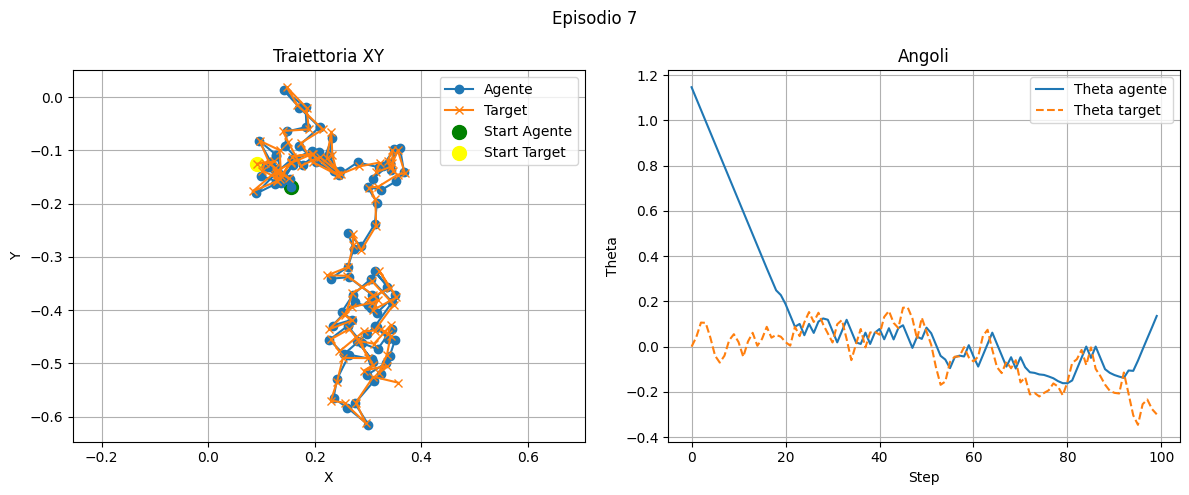

[Episode 8] Steps: 100, Total attached counter: 12, Total transl: 99, Total rot: 12, Final distance: 0.0080, Final rot error: 0.9143, Success: False


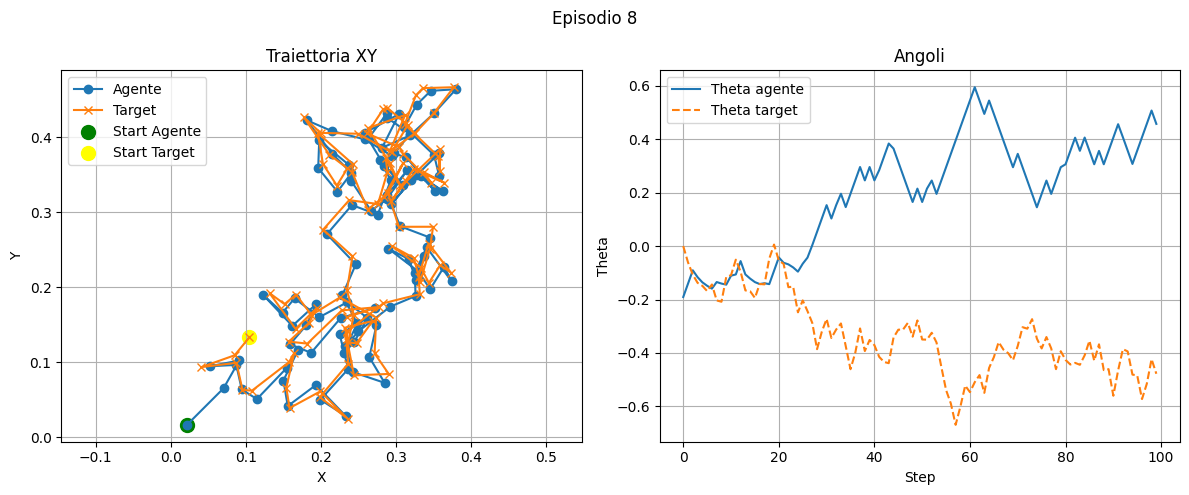

[Episode 9] Steps: 100, Total attached counter: 3, Total transl: 94, Total rot: 3, Final distance: 0.0034, Final rot error: 0.9213, Success: False


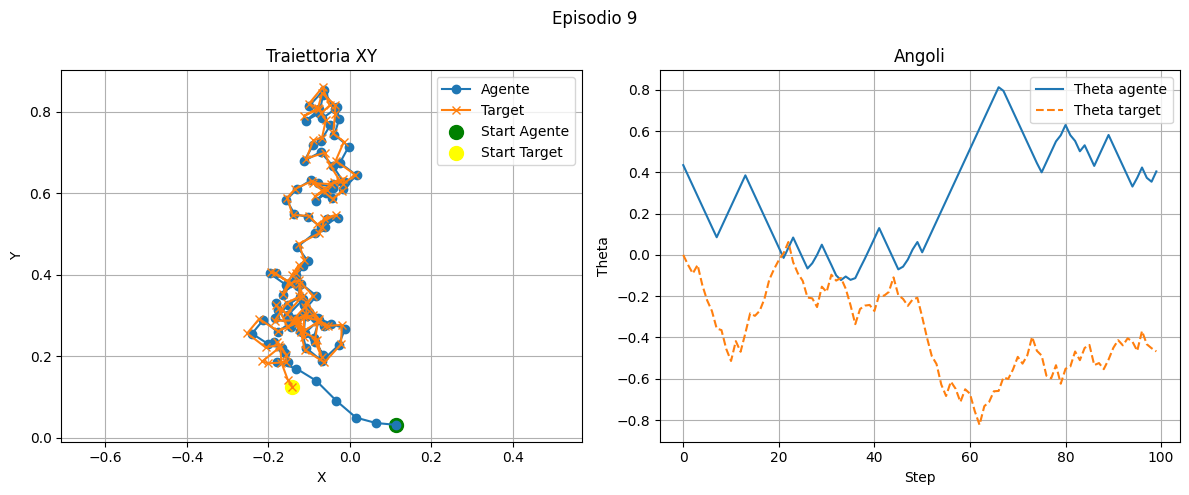


Media distanza finale: 0.0068
Media errore rotazione finale: 1.5035

Media passi attaccati: 9.7000

Media passi attaccati traslazione: 96.3000

Media passi attaccati rotazione: 9.9000
Successi totali: 0 / 10


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from rototransl_env import TrackingEnv
from ddpg_dyn import DDPGAgent as DDPGTranslAgent
from ddpg_rot_dyn import DDPGAgent as DDPGRotAgent


def load_agents(checkpoint_path_transl, checkpoint_path_rot, env=None):
    if env is None:
        env = TrackingEnv()

    state_dim_trasl = 4  # x, y, x_target, y_target
    state_dim_rot = 2    # theta, theta_target

    agent_transl = DDPGTranslAgent(state_dim_trasl, 2)
    agent_rot = DDPGRotAgent(state_dim_rot, 1)

    ckpt_transl = torch.load(checkpoint_path_transl, map_location=torch.device('cpu'))
    ckpt_rot = torch.load(checkpoint_path_rot, map_location=torch.device('cpu'))

    agent_transl.actor.load_state_dict(ckpt_transl['actor_state_dict'])
    agent_rot.actor.load_state_dict(ckpt_rot['actor_state_dict'])

    agent_transl.eval()
    agent_rot.eval()

    return agent_transl, agent_rot

def test_dual_agents(agent_transl, agent_rot, env=None, num_episodes=10, tolerance_transl=0.02, tolerance_rot=0.01):
    if env is None:
        env = TrackingEnv()

    final_distances = []
    final_rot_errors = []
    ep_attached_counter = []
    ep_attached_counter_transl = []
    ep_attached_counter_rot = []
    success_counter = 0

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []
        target_traj = []
        theta_traj = []
        theta_target_traj = []
        attached_counter = 0
        total_attached_counter = 0
        total_attached_counter_transl = 0
        total_attached_counter_rot = 0

        while not done:
            step += 1
            trajectory.append(state[:2].detach().numpy())
            target_traj.append(state[3:5].detach().numpy())
            theta_traj.append(state[2].item())
            theta_target_traj.append(state[5].item())

            with torch.no_grad():
                state_pos = torch.cat([state[:2], state[3:5]], dim=0)
                state_rot = torch.cat([state[2:3], state[5:6]], dim=0)
                action_xy = agent_transl.actor(state_pos)
                action_rot = agent_rot.actor(state_rot)

            action = torch.cat([action_xy, action_rot], dim=0).detach().numpy()
            action = np.clip(action, env.action_space.low, env.action_space.high)

            next_state, _, done, truncated, _, _ = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            dist_transl = torch.norm(next_state[:2] - state[3:5])
            dist_rot = torch.abs(next_state[2] - state[5])

            if dist_transl < tolerance_transl:
                total_attached_counter_transl += 1

            if dist_rot < tolerance_rot:
                total_attached_counter_rot += 1

            if dist_transl < tolerance_transl and dist_rot < tolerance_rot:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0

            done = truncated

            state = next_state

        final_distances.append(dist_transl.item())
        final_rot_errors.append(dist_rot.item())
        ep_attached_counter.append(total_attached_counter)
        ep_attached_counter_transl.append(total_attached_counter_transl)
        ep_attached_counter_rot.append(total_attached_counter_rot)

        success = attached_counter > 20
        if success:
            success_counter += 1

        print(f"[Episode {ep}] Steps: {step}, Total attached counter: {total_attached_counter}, Total transl: {total_attached_counter_transl}, Total rot: {total_attached_counter_rot}, Final distance: {dist_transl:.4f}, Final rot error: {dist_rot:.4f}, Success: {success}")

        if ep % 1 == 0:
            plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, ep, success)

    env.close()
    print(f"\nMedia distanza finale: {np.mean(final_distances):.4f}")
    print(f"Media errore rotazione finale: {np.mean(final_rot_errors):.4f}")
    print(f"\nMedia passi attaccati: {np.mean(ep_attached_counter):.4f}")
    print(f"\nMedia passi attaccati traslazione: {np.mean(ep_attached_counter_transl):.4f}")
    print(f"\nMedia passi attaccati rotazione: {np.mean(ep_attached_counter_rot):.4f}")
    print(f"Successi totali: {success_counter} / {num_episodes}")

def plot_trajectory(trajectory, target_traj, theta_traj, theta_target_traj, episode, success):
    trajectory = np.array(trajectory)
    target_traj = np.array(target_traj)
    theta_traj = np.array(theta_traj)
    theta_target_traj = np.array(theta_target_traj)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    axs[0].plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Agente")
    axs[0].plot(target_traj[:, 0], target_traj[:, 1], marker='x', label="Target")
    axs[0].scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start Agente', s=100)
    axs[0].scatter(target_traj[0, 0], target_traj[0, 1], color='yellow', label='Start Target', s=100)
    axs[0].set_title("Traiettoria XY")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("Y")
    axs[0].legend()
    axs[0].grid(True)
    axs[0].axis('equal')

    axs[1].plot(theta_traj, label="Theta agente")
    axs[1].plot(theta_target_traj, label="Theta target", linestyle='--')
    axs[1].set_title("Angoli")
    axs[1].set_xlabel("Step")
    axs[1].set_ylabel("Theta")
    axs[1].legend()
    axs[1].grid(True)

    plt.suptitle(f"Episodio {episode}")
    plt.tight_layout()
    plt.show()
    plt.close()

# --- MAIN ---
if __name__ == "__main__":
    ckpt_transl = "/Users/edoardozappia/Documents/GitHub/RL_IL_AR_for_surgery/Traslazioni-dinamiche/No-noise/ddpg_run_dyn20250416_200754/checkpoint_ep2950.pth"
    ckpt_rot = "/Users/edoardozappia/Documents/GitHub/RL_IL_AR_for_surgery/Rotazioni-dinamiche/No-noise/ddpg20250503_151134/checkpoint_ep1743.pth"
    agent_transl, agent_rot = load_agents(ckpt_transl, ckpt_rot)
    test_dual_agents(agent_transl, agent_rot)


[Episode 0] Steps: 100, Total attached counter: 0, Success: False


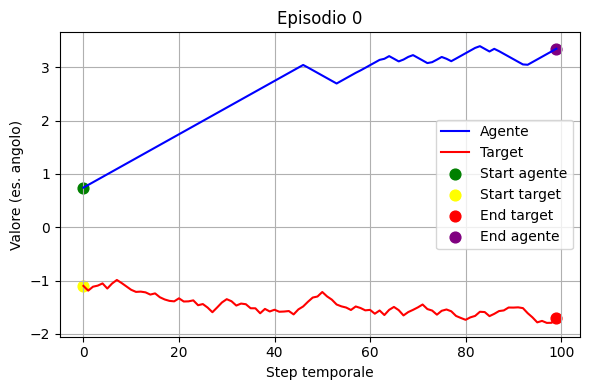

[Episode 1] Steps: 100, Total attached counter: 0, Success: False
[Episode 2] Steps: 100, Total attached counter: 0, Success: False
[Episode 3] Steps: 100, Total attached counter: 0, Success: False
[Episode 4] Steps: 100, Total attached counter: 0, Success: False
[Episode 5] Steps: 100, Total attached counter: 1, Success: False
[Episode 6] Steps: 100, Total attached counter: 0, Success: False
[Episode 7] Steps: 100, Total attached counter: 0, Success: False
[Episode 8] Steps: 100, Total attached counter: 0, Success: False
[Episode 9] Steps: 100, Total attached counter: 0, Success: False
[Episode 10] Steps: 100, Total attached counter: 0, Success: False
[Episode 11] Steps: 100, Total attached counter: 0, Success: False
[Episode 12] Steps: 100, Total attached counter: 0, Success: False
[Episode 13] Steps: 100, Total attached counter: 1, Success: False
[Episode 14] Steps: 100, Total attached counter: 0, Success: False
[Episode 15] Steps: 100, Total attached counter: 13, Success: False
[Ep

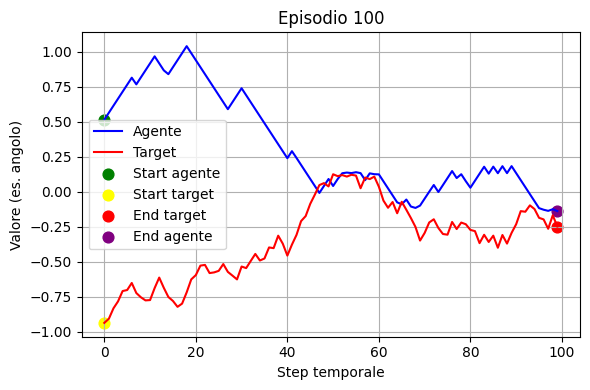

[Episode 101] Steps: 100, Total attached counter: 0, Success: False
[Episode 102] Steps: 100, Total attached counter: 1, Success: False
[Episode 103] Steps: 100, Total attached counter: 0, Success: False
[Episode 104] Steps: 100, Total attached counter: 0, Success: False
[Episode 105] Steps: 100, Total attached counter: 0, Success: False
[Episode 106] Steps: 100, Total attached counter: 0, Success: False
[Episode 107] Steps: 100, Total attached counter: 0, Success: False
[Episode 108] Steps: 100, Total attached counter: 2, Success: False
[Episode 109] Steps: 100, Total attached counter: 1, Success: False
[Episode 110] Steps: 100, Total attached counter: 0, Success: False
[Episode 111] Steps: 100, Total attached counter: 0, Success: False
[Episode 112] Steps: 100, Total attached counter: 0, Success: False
[Episode 113] Steps: 100, Total attached counter: 0, Success: False
[Episode 114] Steps: 100, Total attached counter: 7, Success: False
[Episode 115] Steps: 100, Total attached counter

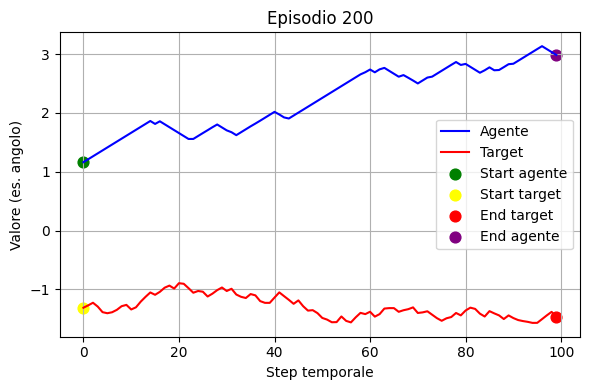

[Episode 201] Steps: 100, Total attached counter: 1, Success: False
[Episode 202] Steps: 100, Total attached counter: 0, Success: False
[Episode 203] Steps: 100, Total attached counter: 0, Success: False
[Episode 204] Steps: 100, Total attached counter: 0, Success: False
[Episode 205] Steps: 100, Total attached counter: 6, Success: False
[Episode 206] Steps: 100, Total attached counter: 0, Success: False
[Episode 207] Steps: 100, Total attached counter: 0, Success: False
[Episode 208] Steps: 100, Total attached counter: 0, Success: False
[Episode 209] Steps: 100, Total attached counter: 15, Success: False
[Episode 210] Steps: 100, Total attached counter: 0, Success: False
[Episode 211] Steps: 100, Total attached counter: 0, Success: False
[Episode 212] Steps: 100, Total attached counter: 0, Success: False
[Episode 213] Steps: 100, Total attached counter: 0, Success: False
[Episode 214] Steps: 100, Total attached counter: 1, Success: False
[Episode 215] Steps: 100, Total attached counte

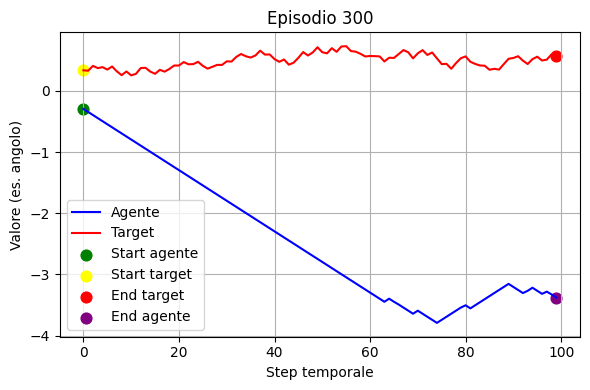

[Episode 301] Steps: 100, Total attached counter: 0, Success: False
[Episode 302] Steps: 100, Total attached counter: 5, Success: False
[Episode 303] Steps: 100, Total attached counter: 0, Success: False
[Episode 304] Steps: 100, Total attached counter: 0, Success: False
[Episode 305] Steps: 100, Total attached counter: 0, Success: False
[Episode 306] Steps: 100, Total attached counter: 0, Success: False
[Episode 307] Steps: 100, Total attached counter: 22, Success: False
[Episode 308] Steps: 100, Total attached counter: 0, Success: False
[Episode 309] Steps: 100, Total attached counter: 1, Success: False
[Episode 310] Steps: 100, Total attached counter: 3, Success: False
[Episode 311] Steps: 100, Total attached counter: 22, Success: False
[Episode 312] Steps: 100, Total attached counter: 0, Success: False
[Episode 313] Steps: 100, Total attached counter: 26, Success: False
[Episode 314] Steps: 100, Total attached counter: 0, Success: False
[Episode 315] Steps: 100, Total attached coun

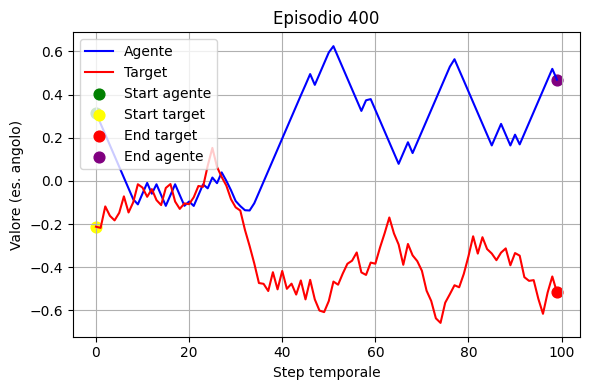

[Episode 401] Steps: 100, Total attached counter: 0, Success: False
[Episode 402] Steps: 100, Total attached counter: 0, Success: False
[Episode 403] Steps: 100, Total attached counter: 8, Success: False
[Episode 404] Steps: 100, Total attached counter: 0, Success: False
[Episode 405] Steps: 100, Total attached counter: 1, Success: False
[Episode 406] Steps: 100, Total attached counter: 8, Success: False
[Episode 407] Steps: 100, Total attached counter: 0, Success: False
[Episode 408] Steps: 100, Total attached counter: 0, Success: False
[Episode 409] Steps: 100, Total attached counter: 2, Success: False
[Episode 410] Steps: 100, Total attached counter: 12, Success: False
[Episode 411] Steps: 100, Total attached counter: 0, Success: False
[Episode 412] Steps: 100, Total attached counter: 0, Success: False
[Episode 413] Steps: 100, Total attached counter: 1, Success: False
[Episode 414] Steps: 100, Total attached counter: 7, Success: False
[Episode 415] Steps: 100, Total attached counte

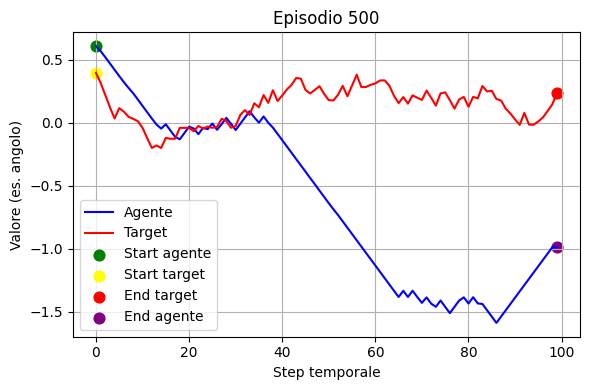

[Episode 501] Steps: 100, Total attached counter: 13, Success: False
[Episode 502] Steps: 100, Total attached counter: 0, Success: False
[Episode 503] Steps: 100, Total attached counter: 1, Success: False
[Episode 504] Steps: 100, Total attached counter: 0, Success: False
[Episode 505] Steps: 100, Total attached counter: 0, Success: False
[Episode 506] Steps: 100, Total attached counter: 0, Success: False
[Episode 507] Steps: 100, Total attached counter: 0, Success: False
[Episode 508] Steps: 100, Total attached counter: 0, Success: False
[Episode 509] Steps: 100, Total attached counter: 4, Success: False
[Episode 510] Steps: 100, Total attached counter: 11, Success: False
[Episode 511] Steps: 100, Total attached counter: 0, Success: False
[Episode 512] Steps: 100, Total attached counter: 0, Success: False
[Episode 513] Steps: 100, Total attached counter: 3, Success: False
[Episode 514] Steps: 100, Total attached counter: 10, Success: False
[Episode 515] Steps: 100, Total attached coun

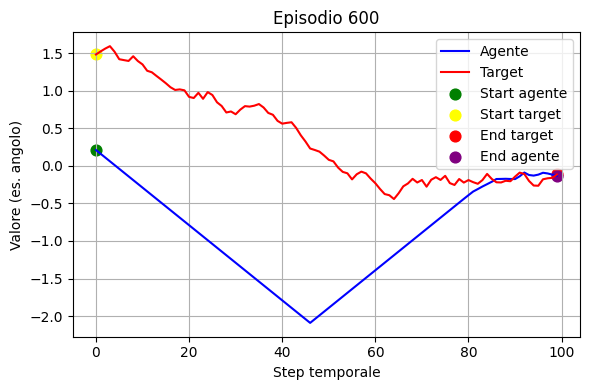

[Episode 601] Steps: 100, Total attached counter: 0, Success: False
[Episode 602] Steps: 100, Total attached counter: 0, Success: False
[Episode 603] Steps: 100, Total attached counter: 0, Success: False
[Episode 604] Steps: 100, Total attached counter: 0, Success: False
[Episode 605] Steps: 100, Total attached counter: 1, Success: False
[Episode 606] Steps: 100, Total attached counter: 10, Success: False
[Episode 607] Steps: 100, Total attached counter: 0, Success: False
[Episode 608] Steps: 100, Total attached counter: 6, Success: False
[Episode 609] Steps: 100, Total attached counter: 0, Success: False
[Episode 610] Steps: 100, Total attached counter: 0, Success: False
[Episode 611] Steps: 100, Total attached counter: 0, Success: False
[Episode 612] Steps: 100, Total attached counter: 0, Success: False
[Episode 613] Steps: 100, Total attached counter: 0, Success: False
[Episode 614] Steps: 100, Total attached counter: 0, Success: False
[Episode 615] Steps: 100, Total attached counte

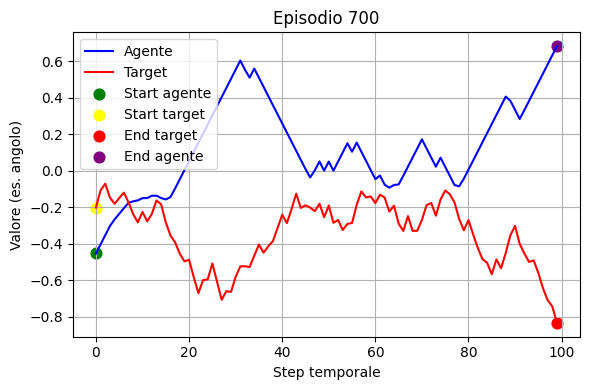

[Episode 701] Steps: 100, Total attached counter: 0, Success: False
[Episode 702] Steps: 100, Total attached counter: 0, Success: False
[Episode 703] Steps: 100, Total attached counter: 0, Success: False
[Episode 704] Steps: 100, Total attached counter: 0, Success: False
[Episode 705] Steps: 100, Total attached counter: 0, Success: False
[Episode 706] Steps: 100, Total attached counter: 19, Success: False
[Episode 707] Steps: 100, Total attached counter: 0, Success: False
[Episode 708] Steps: 100, Total attached counter: 0, Success: False
[Episode 709] Steps: 100, Total attached counter: 0, Success: False
[Episode 710] Steps: 100, Total attached counter: 27, Success: False
[Episode 711] Steps: 100, Total attached counter: 6, Success: False
[Episode 712] Steps: 100, Total attached counter: 12, Success: False
[Episode 713] Steps: 100, Total attached counter: 0, Success: False
[Episode 714] Steps: 100, Total attached counter: 0, Success: False
[Episode 715] Steps: 100, Total attached coun

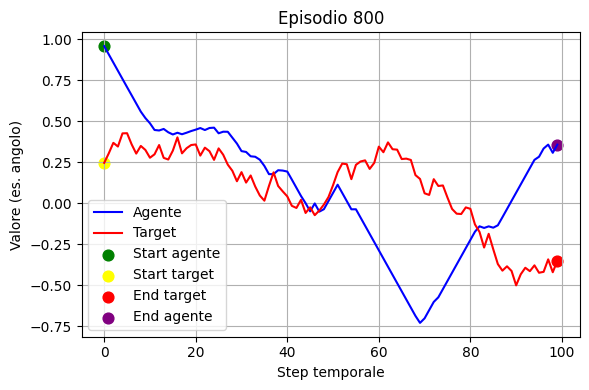

[Episode 801] Steps: 100, Total attached counter: 0, Success: False
[Episode 802] Steps: 100, Total attached counter: 0, Success: False
[Episode 803] Steps: 100, Total attached counter: 0, Success: False
[Episode 804] Steps: 100, Total attached counter: 1, Success: False
[Episode 805] Steps: 100, Total attached counter: 0, Success: False
[Episode 806] Steps: 100, Total attached counter: 0, Success: False
[Episode 807] Steps: 100, Total attached counter: 0, Success: False
[Episode 808] Steps: 100, Total attached counter: 0, Success: False
[Episode 809] Steps: 100, Total attached counter: 0, Success: False
[Episode 810] Steps: 100, Total attached counter: 0, Success: False
[Episode 811] Steps: 100, Total attached counter: 0, Success: False
[Episode 812] Steps: 100, Total attached counter: 0, Success: False
[Episode 813] Steps: 100, Total attached counter: 0, Success: False
[Episode 814] Steps: 100, Total attached counter: 0, Success: False
[Episode 815] Steps: 100, Total attached counter

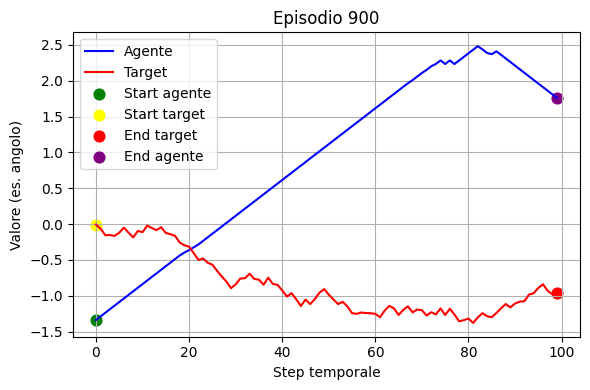

[Episode 901] Steps: 100, Total attached counter: 1, Success: False
[Episode 902] Steps: 100, Total attached counter: 0, Success: False
[Episode 903] Steps: 100, Total attached counter: 14, Success: False
[Episode 904] Steps: 100, Total attached counter: 0, Success: False
[Episode 905] Steps: 100, Total attached counter: 0, Success: False
[Episode 906] Steps: 100, Total attached counter: 0, Success: False
[Episode 907] Steps: 100, Total attached counter: 13, Success: False
[Episode 908] Steps: 100, Total attached counter: 0, Success: False
[Episode 909] Steps: 100, Total attached counter: 9, Success: False
[Episode 910] Steps: 100, Total attached counter: 0, Success: False
[Episode 911] Steps: 100, Total attached counter: 1, Success: False
[Episode 912] Steps: 100, Total attached counter: 0, Success: False
[Episode 913] Steps: 100, Total attached counter: 0, Success: False
[Episode 914] Steps: 100, Total attached counter: 1, Success: False
[Episode 915] Steps: 100, Total attached count

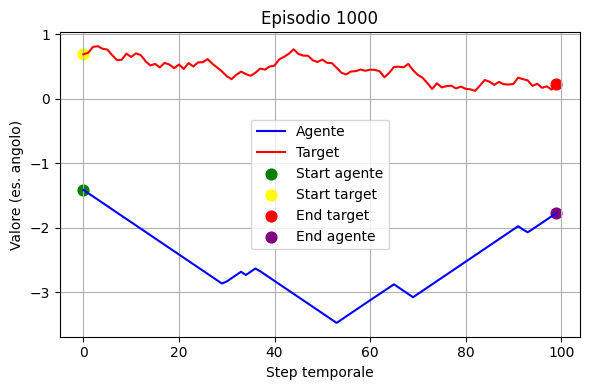


Media distanza finale: 1.9980
Numero successi: 0 / 1001


In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from env_rot import TrackingEnv
from ddpg_rot_dyn import DDPGAgent

def load_agent(checkpoint_path, env=None):
    if env is None:
        env = TrackingEnv()
    state_dim = 2 #env.observation_space.shape[0]
    action_dim = 1 #env.action_space.shape[0]
    agent = DDPGAgent(state_dim, action_dim)

    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    agent.actor.load_state_dict(checkpoint['actor_state_dict'])
    agent.critic.load_state_dict(checkpoint['critic_state_dict'])

    agent.eval()  # Imposta .eval() anche sui moduli interni (se serve, aggiungi)
    return agent

def test_agent_with_random_targets(agent, env=None, num_episodes=1001, tolerance=0.01):
    if env is None:
        env = TrackingEnv()

    ep_attached_counter = []
    success_counter = 0

    for ep in range(num_episodes):
        state, _ = env.reset()

        real_state = torch.tensor(state, dtype=torch.float32)
        state = torch.tensor(state, dtype=torch.float32)
        
        # state = state.clone()
        # state[2:4] += torch.normal(mean=0.0, std=0.005, size=(2,), device=state.device)

        done = False
        step = 0
        trajectory = []
        target_trajectory = []
        attached_counter = 0
        total_attached_counter = 0

        while not done:
            trajectory.append(state[0].detach().numpy())
            target_trajectory.append(state[1].detach().numpy())
            with torch.no_grad():
                action = agent.actor(state).detach().numpy()
            next_state, _, done, truncated, _ = env.step(action)

            real_next_state = torch.tensor(next_state, dtype=torch.float32)
            next_state = torch.tensor(next_state, dtype=torch.float32)

            # next_state = next_state.clone()
            # next_state[2:4] += torch.normal(mean=0.0, std=0.005, size=(2,), device=next_state.device)

            if torch.norm(real_next_state[0] - real_state[1]) < tolerance:
                total_attached_counter += 1
                attached_counter += 1
            else:
                attached_counter = 0
            
            #if attached_counter > 20 or truncated:
            #    done = True

            done = truncated

            state = next_state
            real_state = real_next_state
            step += 1

        ep_attached_counter.append(total_attached_counter)

        success = attached_counter > 20
        if success:
            success_counter += 1

        print(f"[Episode {ep}] Steps: {step}, Total attached counter: {total_attached_counter}, Success: {success}")

        if ep % 100 == 0:
            trajectory = np.array(trajectory)
            target_trajectory = np.array(target_trajectory)
            plt.figure(figsize=(6, 4))
            plt.plot(trajectory, label="Agente", color='blue')
            plt.plot(target_trajectory, label="Target", color='red')
            plt.scatter(0, trajectory[0], color='green', label='Start agente', s=60)
            plt.scatter(0, target_trajectory[0], color='yellow', label='Start target', s=60)
            plt.scatter(len(target_trajectory) - 1, target_trajectory[-1], color='red', label='End target', s=60)
            plt.scatter(len(trajectory) - 1, trajectory[-1], color='purple', label='End agente', s=60)
            plt.title(f"Episodio {ep}")
            plt.xlabel("Step temporale")
            plt.ylabel("Valore (es. angolo)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()            
            plt.show()                    

    env.close()
    print(f"\nMedia distanza finale: {np.mean(ep_attached_counter):.4f}")
    print(f"Numero successi: {success_counter} / {num_episodes}")

if __name__ == "__main__":
    checkpoint = "/Users/edoardozappia/Documents/GitHub/RL_IL_AR_for_surgery/Rotazioni-dinamiche/No-noise/ddpg20250503_151134/checkpoint_ep1743.pth"
    agent = load_agent(checkpoint)
    test_agent_with_random_targets(agent)